# Testing Quantum Chemistry Calculations

This notebook demonstrates how to use the quantum chemistry package for both single and parallel calculations.

In [1]:
from project_3_indicator import run_calculation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def plot_indicators_comparison(results, show_plot=True, save_path=None, n_columns=2):
    """
    Plot ontop vs dynamic indicators comparison for multiple basis sets in all available directions.
    Works with both single dictionary and list of dictionaries input.

    Parameters:
    -----------
    results : dict or list of dict
        Single dictionary or list of dictionaries containing results data, each with:
        - ontop_data: DataFrame with columns [atom, direction, r, ontop, density, indicator_dynamic]
        - basis_name: str, name of basis set
        - method_name: str, name of method
        - molecule_name: str, name of molecule
    show_plot : bool, optional
        Whether to display the plot (default True)
    save_path : str, optional
        Path to save the plot (if None, plot is not saved)
    n_columns : int, optional
        Number of columns for multiple direction plots (default 2)

    Returns:
    --------
    fig : matplotlib figure
        The generated comparison plot figure
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import math

    # Try to import IPython display tools
    try:
        from IPython.display import clear_output, display
        in_notebook = True
    except ImportError:
        in_notebook = False

    # Store error messages to display them only if needed
    error_messages = []

    # Convert single dictionary to list for uniform processing
    results_list = [results] if isinstance(results, dict) else results

    # Input validation
    if not results_list:
        raise ValueError("Input cannot be empty")

    # Filter valid results
    valid_results = []
    for result in results_list:
        if not isinstance(result, dict):
            error_messages.append(f"Skipping invalid result: not a dictionary")
            continue

        if 'ontop_data' not in result or not isinstance(result['ontop_data'], pd.DataFrame):
            error_messages.append(f"Skipping calculation for basis {result.get('basis_name', 'unknown')}: missing or invalid ontop data")
            continue

        # Check if DataFrame contains required columns
        required_columns = ['atom', 'direction', 'r', 'ontop', 'density', 'indicator_dynamic']
        if not all(col in result['ontop_data'].columns for col in required_columns):
            error_messages.append(f"Skipping calculation for basis {result.get('basis_name', 'unknown')}: missing required columns")
            continue

        valid_results.append(result)

    if not valid_results:
        if error_messages:
            print("\n".join(error_messages))
        raise ValueError("No valid calculations to plot")

    # Get unique directions from the first valid result
    directions = sorted(valid_results[0]['ontop_data']['direction'].unique())
    n_directions = len(directions)

    # Calculate number of rows needed
    n_rows = math.ceil(n_directions / n_columns)

    # Create plot with subplots
    fig, axes = plt.subplots(n_rows, min(n_directions, n_columns),
                            figsize=(6*min(n_directions, n_columns), 6*n_rows),
                            squeeze=False)  # squeeze=False ensures axes is always 2D

    # Flatten axes for easier iteration
    axes_flat = axes.flatten()

    colors = ['b', 'r', 'g', 'm', 'c', 'y']  # Color cycle

    # Plot data for each valid calculation
    plot_errors = []
    for i, result in enumerate(valid_results):
        try:
            df = result['ontop_data']
            basis = result['basis_name']
            color = colors[i % len(colors)]

            # Calculate indicators
            df['X(r)'] = 2 * df['ontop'] / (df['density']**2)
            df['X_dyn(r)'] = df['indicator_dynamic']

            # Plot for each direction
            for dir_idx, direction in enumerate(directions):
                ax = axes_flat[dir_idx]
                direction_data = df[df['direction'] == direction]

                ax.plot(direction_data['r'], direction_data['X(r)'],
                       f'{color}-', linewidth=2, label=f'X(r) - {basis}')
                ax.plot(direction_data['r'], direction_data['X_dyn(r)'],
                       f'{color}--', linewidth=2, label=f'I_D(r) - {basis}')

        except Exception as e:
            plot_errors.append(f"Error plotting basis {basis}: {str(e)}")
            continue

    # Add labels and titles
    if 'method_name' in valid_results[0] and 'molecule_name' in valid_results[0]:
        method = valid_results[0]['method_name']
        molecule = valid_results[0]['molecule_name']
        fig.suptitle(f'Indicator Comparison - {molecule} ({method})', fontsize=16)
    else:
        fig.suptitle('Indicator Comparison', fontsize=16)

    # Customize each subplot
    for idx, (direction, ax) in enumerate(zip(directions, axes_flat)):
        ax.set_xlabel('r (Å)', fontsize=12)
        ax.set_ylabel('Indicator Value', fontsize=12)
        ax.set_title(f'Direction {direction}', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.margins(x=0.02)
        ax.legend(fontsize=10, loc='upper right')

    # Hide empty subplots if any
    for idx in range(len(directions), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    fig.tight_layout(pad=2.0)

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show if requested
    if show_plot:
        if in_notebook:
            # Clear previous output and show only the plot
            clear_output(wait=True)
            display(fig)
            plt.close(fig)  # Close the figure to prevent double display
        else:
            plt.show()
    else:
        plt.close(fig)

    # If there were any errors and we're not in a notebook, print them
    if not in_notebook and (error_messages or plot_errors):
        print("\nErrors encountered:")
        if error_messages:
            print("\n".join(error_messages))
        if plot_errors:
            print("\n".join(plot_errors))

    return fig

## Single Calculation Example

First, let's run a single calculation for helium with CASSCF method.

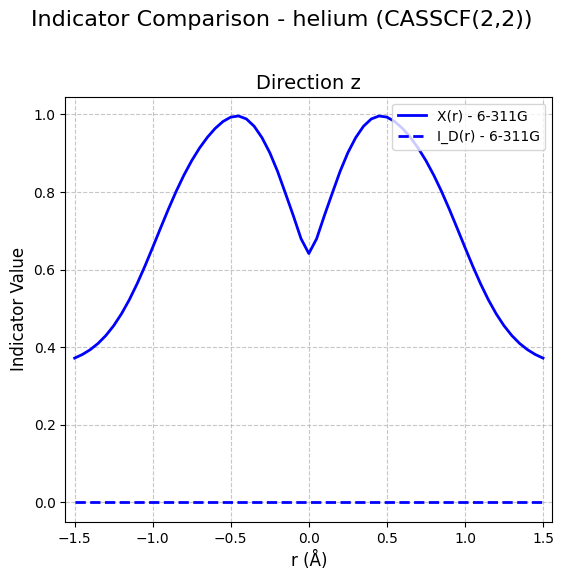

In [3]:
#Run single calculation
single_result = run_calculation(
    molecule_name="helium",
    method_name="CASSCF(2,2)",
    basis_name="6-311G"
)

fig = plot_indicators_comparison(single_result)



## Stored result example

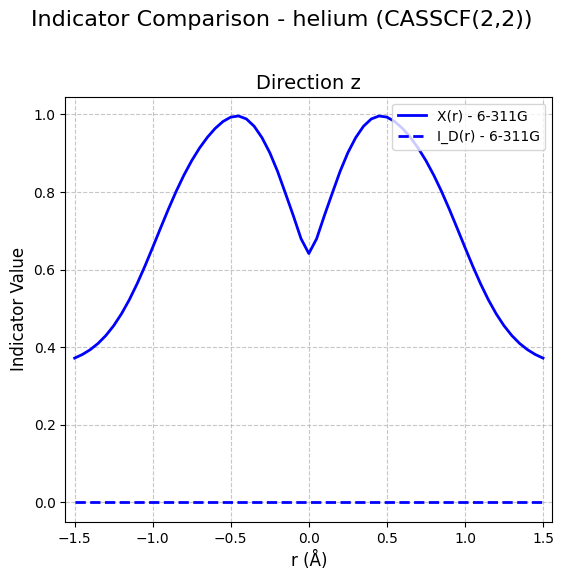

In [4]:
#Run single calculation
single_result = run_calculation(
    molecule_name="helium",
    method_name="CASSCF(2,2)",
    basis_name="6-311G"
)

fig = plot_indicators_comparison(single_result)


## Parallel Calculations Example

Now, let's run parallel calculations using different basis sets.

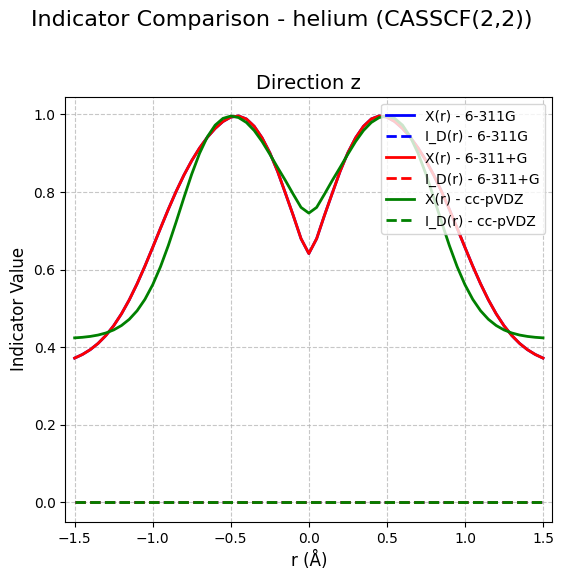

In [5]:
#Run seevral calculations
basis = ["6-311G","6-311+G", 'cc-pVDZ']
several_results = run_calculation(
    molecule_name="helium",
    method_name="CASSCF(2,2)",
    basis_name=basis
)

fig = plot_indicators_comparison(several_results)


## Now with several atom molecules

Let's compare different methods using the same basis set.

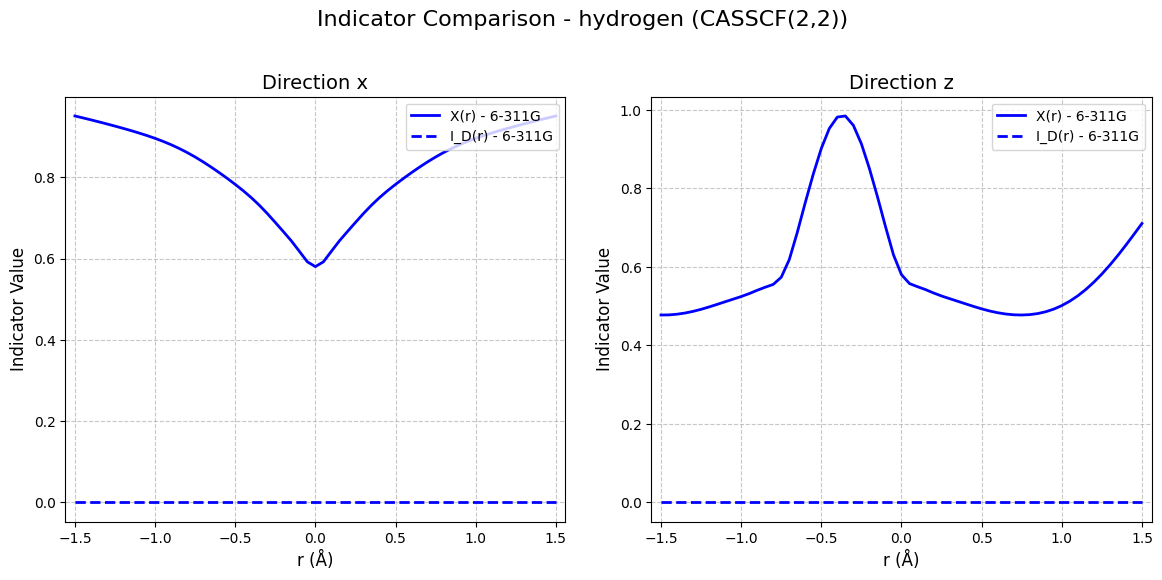

In [6]:
#Run single calculation
single_result = run_calculation(
    molecule_name="hydrogen",
    method_name="CASSCF(2,2)",
    basis_name="6-311G",
    scanning_props={'directions':'x,z'}
)

fig = plot_indicators_comparison(single_result)

